# Spherical Harmonics from Scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from scipy.special import sph_harm, eval_legendre
from matplotlib.colors import LightSource
from IPython import display

In [2]:
N_POINTS = 50
theta = np.linspace(0, np.pi, N_POINTS)
phi = np.linspace(0, 2 * np.pi, N_POINTS)
theta, phi = np.meshgrid(theta, phi)

In [3]:
# The Cartesian coordinates of the unit sphere
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

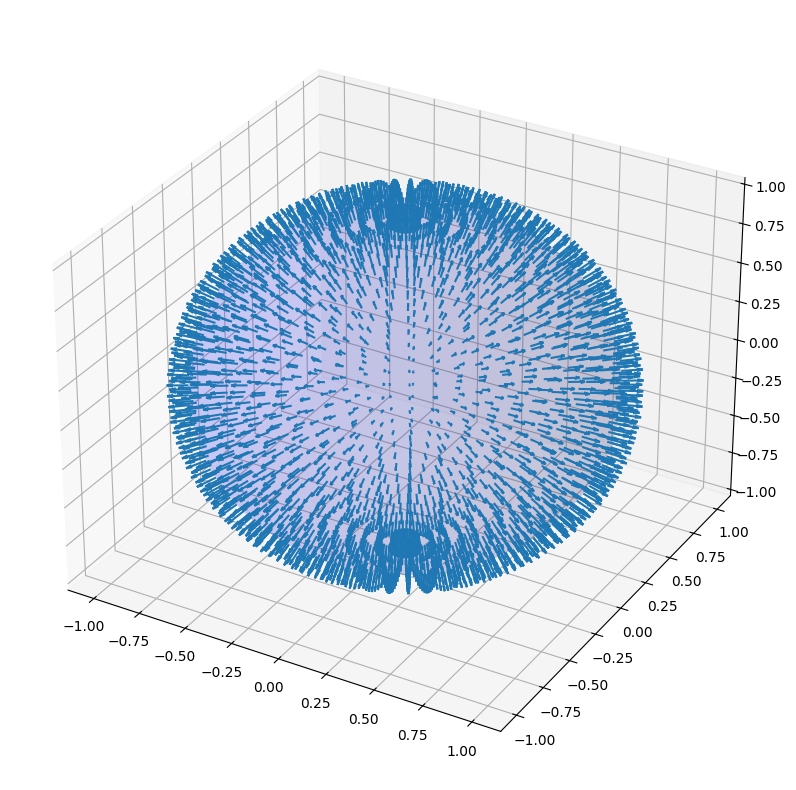

In [19]:
# Plot the vectors on the sphere
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, color='b', alpha=0.1)
ax.quiver(x, y, z, x, y, z, length=0.1)
plt.show()

In [5]:
def calculate_K(l: int, m: int) -> float:
    return np.sqrt(
        (2 * l + 1)
        / (4 * np.math.pi)
        * np.math.factorial(l - m)
        / np.math.factorial(l + m)
    )

In [6]:
def calculate_P(l: int, m: int, x: float) -> float:
    pmm = 1.0  # value of polynomial when l == m
    if m > 0:
        somx2 = np.sqrt((1.0 - x) * (1.0 + x))
        fact = 1.0  # factor, increasing by 2 at each iter
        for i in range(1, m + 1):
            pmm *= -fact * somx2
            fact += 2.0
    if l == m:
        return pmm

    pmmp1 = x * (2.0 * m + 1.0) * pmm  # value of polynomial when l == m + 1
    if l == m + 1:
        return pmmp1

    pll = 0.0  # value of polynomial when l > m + 1
    for ll in range(m + 2, l + 1):
        pll = ((2.0 * ll - 1.0) * x * pmmp1 - (ll + m - 1.0) * pmm) / (ll - m)
        pmm = pmmp1
        pmmp1 = pll

    return pll

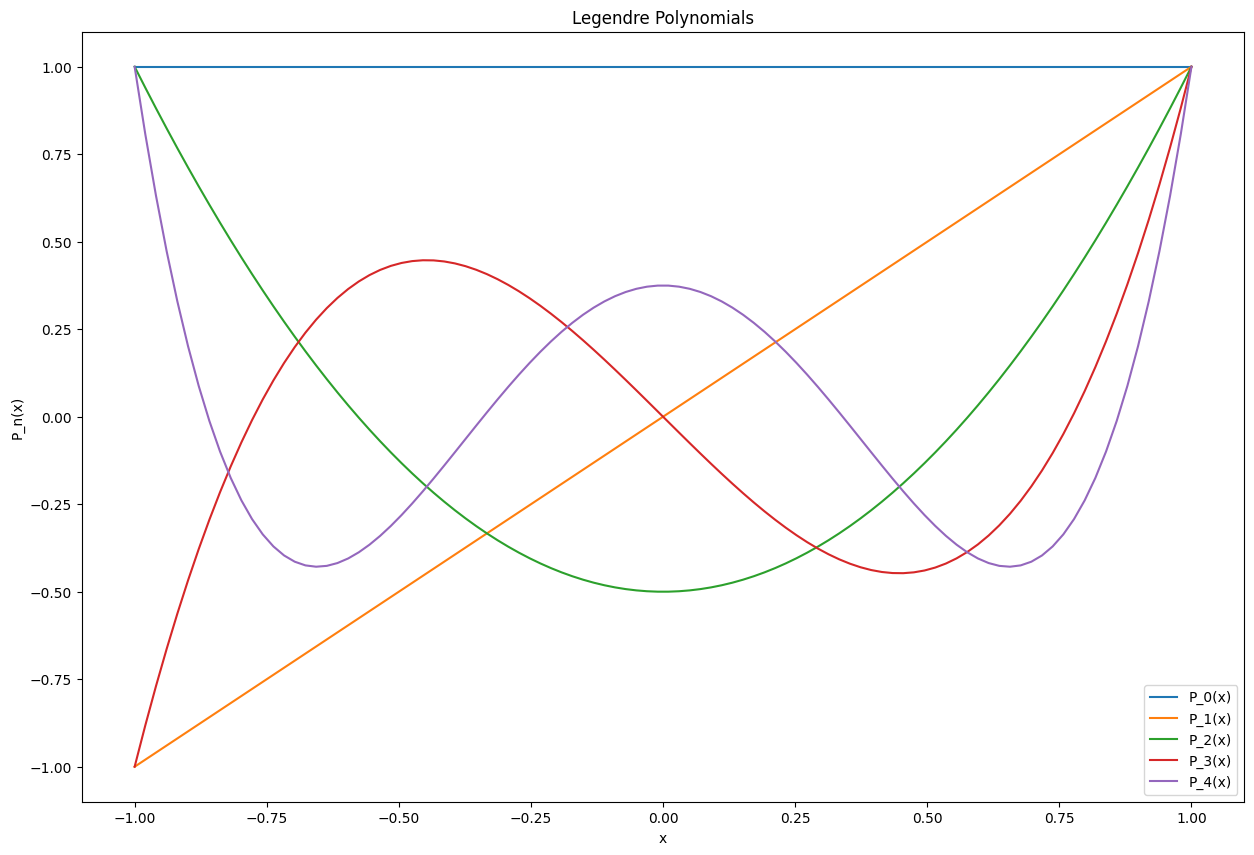

In [17]:
# Plotting legendre polynomials
fig = plt.figure(figsize=(15, 10))
xs = np.linspace(-1, 1, 100)

for l in range(5):
    ys = [calculate_P(l, 0, x) for x in xs]
    plt.plot(xs, ys, label=f"P_{l}(x)")

plt.title("Legendre Polynomials")
plt.xlabel("x")
plt.ylabel("P_n(x)")
plt.legend()
plt.show()

In [7]:
class SH:
    def __init__(self, l: int, m: int, theta: float, phi: float):
        self.l = l
        self.m = m
        self.theta = theta
        self.phi = phi
        self.K = calculate_K(l, m) if m >= 0 else ((-1) ** m) * calculate_K(l, m)
        self.P = (
            calculate_P(l, m, np.cos(theta))
            if m >= 0
            else ((-1) ** m) * calculate_P(l, m, np.cos(theta))
        )
        self.value = self.K * self.P * np.exp(1j * m * phi)
        self.imag = np.imag(self.value)
        self.real = np.real(self.value)

In [8]:
def get_sphere_harmonic(l: int, m: int, component: str):
    sh_ = SH(l, m, theta, phi)
    # sh_ = sph_harm(m, l, phi, theta) # You can use scipy, instead!
    if component == "abs":
        r_, i_ = sh_.real, sh_.imag
        fcolors = np.sqrt(r_**2 + i_**2)
    else:
        fcolors = sh_.real if component == "real" else sh_.imag

    wavefun = fcolors
    f_max, f_min = wavefun.max(), wavefun.min()
    fcolors = (wavefun - f_min) / (f_max - f_min + 1e-10)
    ls = LightSource(azdeg=180, altdeg=45)
    rgb = ls.shade(fcolors, cmap=cm.seismic, vert_exag=0.1, blend_mode="soft")

    if np.unique(fcolors).size == 1:
        rgb = np.tile(np.array([1, 0, 0, 1]), (rgb.shape[0], rgb.shape[1], 1))

    return wavefun, rgb

In [9]:
def animator(rgb, r, fig, ax, mode):
    def init():
        for rgbi, axi, ri in zip(rgb, ax, r):
            ri = np.abs(np.squeeze(np.array(ri)))
            if mode == "sphere":
                axi.plot_surface(
                    x, y, z, rstride=1, cstride=1, facecolors=rgbi, shade=False
                )
            if mode == "radial":
                axi.plot_surface(
                    np.multiply(ri, x),
                    np.multiply(ri, y),
                    np.multiply(ri, z),
                    rstride=1,
                    cstride=1,
                    facecolors=rgbi,
                    shade=False,
                )
            axi.set_axis_off()

        return (fig,)

    def animate(i):
        for axi in ax:
            axi.view_init(elev=30, azim=0 + 10 * i)
        return (fig,)

    ani = animation.FuncAnimation(
        fig, animate, init_func=init, frames=100, interval=50, blit=True
    )
    return ani

In [10]:
def generate_all_harmonics(l: int, mode: str):
    for m in range(-l, l + 1):
        print(f"l={l}, m={m}")
        fig = plt.figure(figsize=plt.figaspect(0.5))

        realR, real_img = get_sphere_harmonic(l, m, "real")
        imag, imag_img = get_sphere_harmonic(l, m, "imag")

        real_ax = fig.add_subplot(121, projection="3d")
        imag_ax = fig.add_subplot(122, projection="3d")
        all_axes = [real_ax, imag_ax]

        ani = animator([real_img, imag_img], [realR, imag], fig, all_axes, mode)
        video = ani.to_html5_video()
        html = display.HTML(video)
        display.display(html)
        plt.close()

In [11]:
generate_all_harmonics(1, "sphere")

l=1, m=-1


l=1, m=0


l=1, m=1
